In [79]:
#Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [171]:
#Import dataset
journey = pd.read_csv('/Users/chelseavalencia/Desktop/prospect_user_journey_dataset.csv')

In [189]:
#Create new column indicating if prospect purchased product
# journey['purchase'] = np.where(journey['event_name'] == 'Checkout', 1, 0)

#Create flag if user completed purchase
journey['purchased'] = journey.groupby('user_id')['event_name'].transform(lambda events: 1 if 'Checkout' in events.values else 0)

In [173]:
#Select small sample to test code
journey_small = journey.head(20)

In [174]:
#Sort values by user_id and event timestamp to create sequential order
data_sorted = journey_small.sort_values(by=['user_id', 'event_timestamp'])

#Group events by the user_id and event_name and convert to list format
grouped = data_sorted.groupby('user_id')['event_name'].apply(list)

In [175]:
#View grouped dataframe
grouped

user_id
1    [Add to Cart, View Product, Homepage Visit, Vi...
2    [Homepage Visit, View Product, Add to Cart, Vi...
3             [View Product, Homepage Visit, Checkout]
Name: event_name, dtype: object

In [177]:
#Convert the Series into a dataframe in order to add a new column
grouped = pd.DataFrame(grouped)

#Identify users that made a purchase
conversion = data_sorted[['user_id', 'purchased']].drop_duplicates(keep = 'first')

#Merge grouped dataset with purchase dataset 
grouped = pd.merge(grouped, conversion, on='user_id', how ='left')

In [178]:
grouped.head()

,user_id,event_name,purchased
0,1,"[Add to Cart, View Product, Homepage Visit, Vi...",0
1,2,"[Homepage Visit, View Product, Add to Cart, Vi...",0
2,3,"[View Product, Homepage Visit, Checkout]",1


In [179]:
#Create purchase paths
#Each path has a beginning point and either ends in a purchase or no purchase
grouped['path'] = np.where(
    grouped['purchased'] == 0, 
    ['Start, '] + grouped['event_name'].apply(', '.join) + [', No Purchase'],
    ['Start, '] + grouped['event_name'].apply(', '.join) + [', Purchase'])

#Split the column contents based on delimited identifier
grouped['path'] = grouped['path'].str.split(', ')

In [180]:
#QA paths output
grouped.path

0    [Start, Add to Cart, View Product, Homepage Vi...
1    [Start, Homepage Visit, View Product, Add to C...
2    [Start, View Product, Homepage Visit, Checkout...
Name: path, dtype: object

In [181]:
#Initialize nested dictionary to store transition counts 
#The outer dictionary holds the current state, and the inner dictionary maps to the counts of next states
transition_counts = defaultdict(lambda: defaultdict(int))

#Iterate through each sequence in the 'path' column of the grouped dataset
for sequence in grouped.path:
    #Loop through each state in the state in the sequence, up to the last state 
    for i in range(len(sequence) - 1):
        #Identify the current state in the sequence
        current_state = sequence[i]
        #Identify next state immediately following the current state
        next_state = sequence[+1]
        #Count of transitions from current state to next state
        transition_counts[current_state][next_state] += 1
        
#Print transition counts
print(dict(transition_counts))

{'Start': defaultdict(<class 'int'>, {'Add to Cart': 1, 'Homepage Visit': 1, 'View Product': 1}), 'Add to Cart': defaultdict(<class 'int'>, {'Add to Cart': 5, 'Homepage Visit': 1}), 'View Product': defaultdict(<class 'int'>, {'Add to Cart': 2, 'Homepage Visit': 2, 'View Product': 1}), 'Homepage Visit': defaultdict(<class 'int'>, {'Add to Cart': 4, 'Homepage Visit': 3, 'View Product': 1}), 'Checkout': defaultdict(<class 'int'>, {'View Product': 1})}


In [182]:
#Initialize dictionary to prep transition counts for matrix
transition_matrix_counts = defaultdict(dict)

#Iterate through each state and corresponding transitions in the previously created transition_counts nested dictionary
for state, transitions in transition_counts.items():
    #Calculate the total number of transitions from the current state
    total_transitions = sum(transitions.values())
    #Iterate through each next state and the count of transitions from the current state to that state
    for next_state, count in transitions.items():
        #Count of transitions from the current state to the next state
        transition_matrix_counts[state][next_state] = count
        
#Print matrix transition counts
print(dict(transition_matrix_counts))

{'Start': {'Add to Cart': 1, 'Homepage Visit': 1, 'View Product': 1}, 'Add to Cart': {'Add to Cart': 5, 'Homepage Visit': 1}, 'View Product': {'Add to Cart': 2, 'Homepage Visit': 2, 'View Product': 1}, 'Homepage Visit': {'Add to Cart': 4, 'Homepage Visit': 3, 'View Product': 1}, 'Checkout': {'View Product': 1}}


In [183]:
#Identify unique event names in the dataset
states = sorted(journey['event_name'].unique())

#Create a dataframe to hold the transition counts from a current event to next event
transition_df_counts = pd.DataFrame(0, index=states, columns=states, dtype=float)

#Iterate through each state and corresponding transitions in the previously created transition_matrix_counts dictionary
for state, transitions in transition_matrix_counts.items():
    #Iterate through each next state and the count of transitions from the current state to that state
    for next_state, count in transitions.items():
        #Index transition_df_counts dataframe based on transition and assign count
        transition_df_counts.loc[state, next_state] = count

#Fill in NA values with 0
transition_df_counts.fillna(0, inplace=True)

In [184]:
#View transition_df_counts dataframe
transition_df_counts

,Add to Cart,Checkout,Homepage Visit,Request Product Info,View Product
Add to Cart,5.0,0.0,1.0,0.0,0.0
Checkout,0.0,0.0,0.0,0.0,1.0
Homepage Visit,4.0,0.0,3.0,0.0,1.0
Request Product Info,0.0,0.0,0.0,0.0,0.0
View Product,2.0,0.0,2.0,0.0,1.0
Start,1.0,0.0,1.0,0.0,1.0


In [185]:
#Initialize dictionary to prep for matrix
transition_matrix = defaultdict(dict)

#Iterate through each state and corresponding transitions in the previously created transition_counts dictionary
for state, transitions in transition_counts.items():
    #Calculate the total number of transitions from the current state
    total_transitions = sum(transitions.values())
    #Iterate through each next state and the count of transitions from the current state to that state
    for next_state, count in transitions.items():
        #Calcluate probability of transitioning from current state to next state
        transition_matrix[state][next_state] = count / total_transitions

#Print matrix transition counts
print(dict(transition_matrix))

{'Start': {'Add to Cart': 0.3333333333333333, 'Homepage Visit': 0.3333333333333333, 'View Product': 0.3333333333333333}, 'Add to Cart': {'Add to Cart': 0.8333333333333334, 'Homepage Visit': 0.16666666666666666}, 'View Product': {'Add to Cart': 0.4, 'Homepage Visit': 0.4, 'View Product': 0.2}, 'Homepage Visit': {'Add to Cart': 0.5, 'Homepage Visit': 0.375, 'View Product': 0.125}, 'Checkout': {'View Product': 1.0}}


In [186]:
#Identify unique event names in the dataset
states = sorted(journey['event_name'].unique())

#Create a dataframe to hold the transitions from a current event to next event
transition_df = pd.DataFrame(0, index=states, columns=states, dtype=float)

#Iterate through each state and corresponding transitions in the previously created transition_matrix dictionary
for state, transitions in transition_matrix.items():
    #Iterate through each next state and probability of transitioning from current state
    for next_state, prob in transitions.items():
        #Index transition_df dataframe based on transition and assign probability
        transition_df.loc[state, next_state] = round(prob,3)
        
#Fill NA values with 0 
transition_df.fillna(0, inplace=True)

<Axes: >

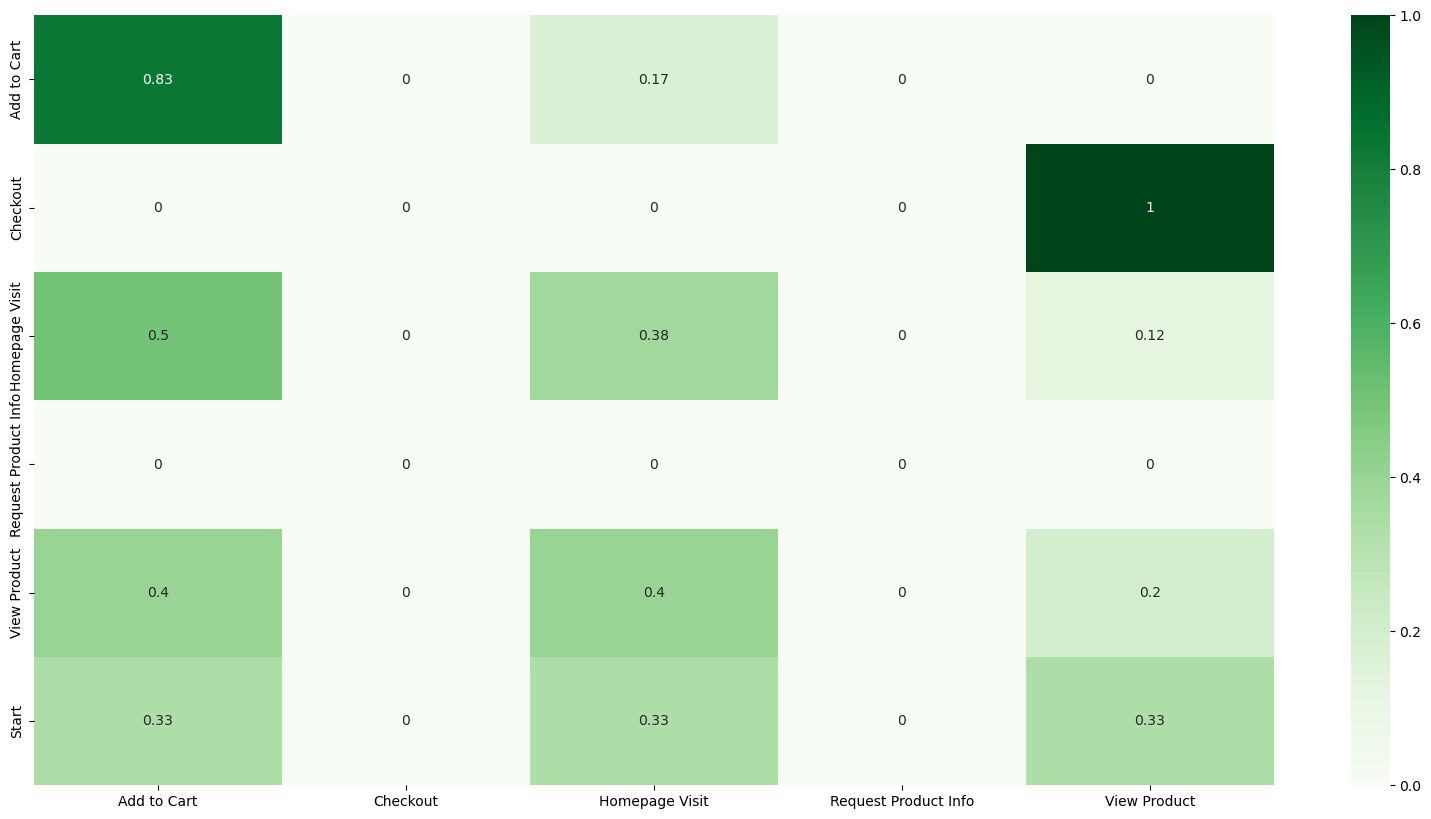

In [187]:
#Create plot figure
plt.figure(figsize=(20,10))

#Create heatmap based on transition probabilities
sns.heatmap(transition_df, annot=True, cmap="Greens")

<Axes: >

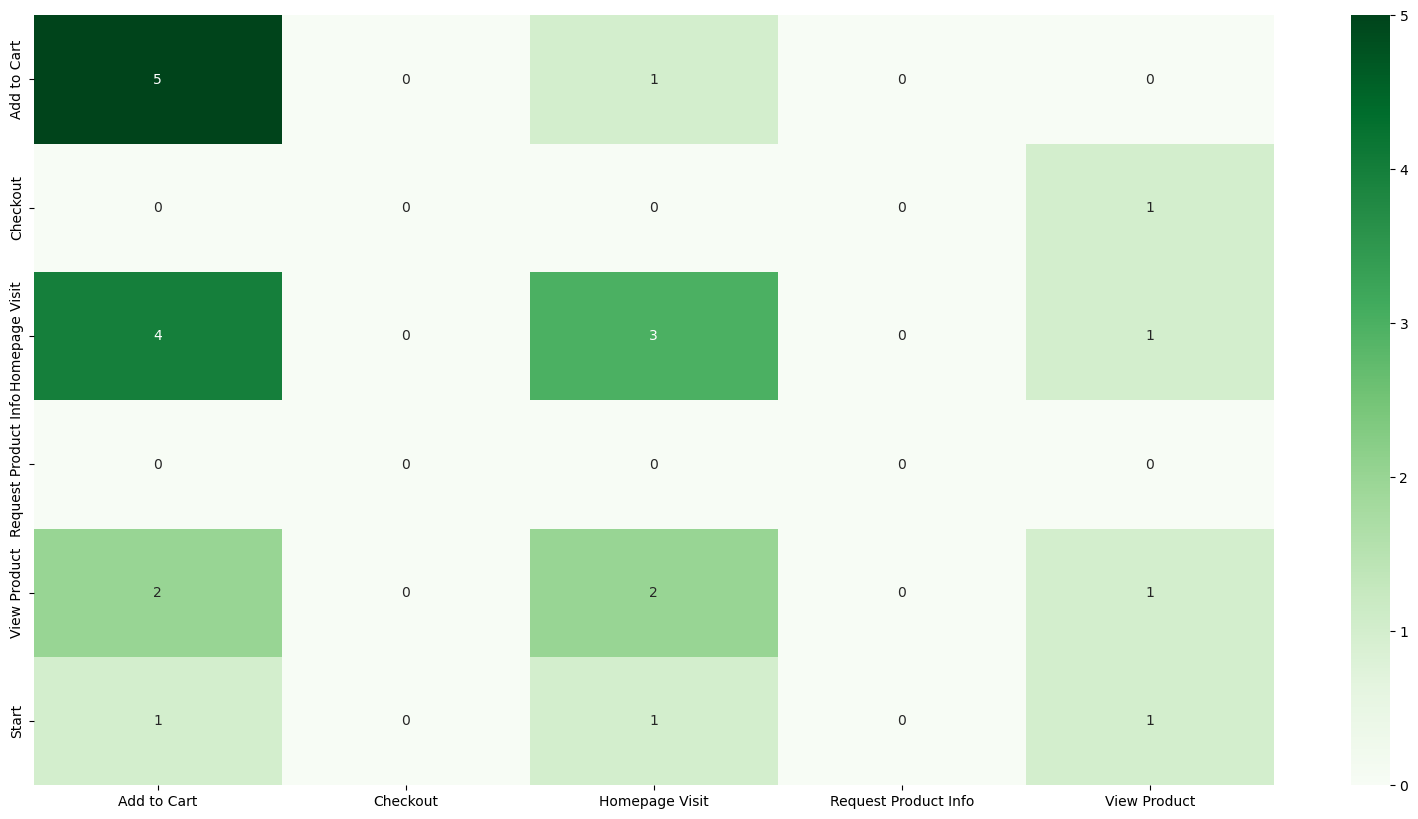

In [188]:
#Create plot figure
plt.figure(figsize=(20,10))

#Create heatmap based on transition values
sns.heatmap(transition_df_counts, annot=True, fmt=".0f", cmap="Greens")

In [ ]:
list_of_paths = grouped['path']

total_conversions = sum(path.count('conversion') for path in grouped['path'].tolist())

base_conversion_rate = total_conversions / len(list_of_paths)

In [120]:
#Initialize dictionary to hold value of removing specific stage
removal_effects_dict = {}

#Iterate through each event in the transition_df_counts dataframe
for event in transition_df_counts.index:
    #Skip "Start", "No Purchase" and "Purchase" events
    if event not in ('Start', 'No Purchase', 'Purchase'):
        #Create new dataframe to hold values excluding the dropped event
        new_df = transition_df_counts.drop(event, axis=1).drop(event, axis=0)
        #Calculate new purchase rate
        new_conversion = new_df.purchase.sum() / new_df.loc['Start']['Purchase']
    #Add value to removal_effects dictionary   
    removal_effects_dict[event] = new_conversion

AttributeError: 'DataFrame' object has no attribute 'Conversion'

In [ ]:
#Convert items in removal_effects dictionary to a dataframe
removal_df = pd.DataFrame(removal_effects_dict.items())

# removal_df_filtered = removal_df.sort_values(1, ascending = True).head(20)

#Create bar chart to visualize change in purchase rate with specific states removed
removal_df_filtered.plot.bar(x=0, y=1, figsize(20,5),
                             title = "Purchase Rate based on Dropout Stage"
                             ylabel = "Purchase Rate"
                             xlabel = "State Removed from Model")                             

In [ ]:
# dropout_counts = {}
# dropout_state = ['Null']

# for state in transition_df.index:
#     dropout_counts[state] = transition_df.loc[state, dropout_state].sum()

In [ ]:
# #Removal effect
# removal_effects_dict = {}

# #turn transition counts into dataframe
# for event in transition_df.index:
#     if event not in ('Start', 'Null', 'Conversion'):
#         new_df = transition_df.drop(event, axis=1).drop(event, axis=0)
#         new_conversion = sum(new_df['Conversion'])
#     removal_effects_dict[event] = new_conversion